# Labeled Convolutional CVAE

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Load pallets library from project root
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pallets import (
    images as I,
    datasets as DS,
    models as M,
    logging as L
)


# Settings

In [3]:
SAVE_NAME = 'cvae.labeledconv'

In [4]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = 'pallets_labels.json'

TEST_SIZE = 1000
EPOCHS = 100
LR = 3e-04
BATCH_SIZE = 32


In [5]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


<Logger pallets (INFO)>

# Dataset

In [6]:
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)
dataset = DS.OneHotCPunksDataset(
    mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
)

# Uncomment to put entire dataset in GPU RAM
# dataset = DS.FastOneHotCPunksDataset(
#     device, mapper, labels_file=LABELS_FILE, test_size=TEST_SIZE
# )

In [7]:
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

# Training

In [8]:
input_dim = 222
latent_dim = 32
classes_dim = len(dataset._label_keys)  # 92

In [9]:
model = M.cvae.LabeledConvCVAE(input_dim, latent_dim, classes_dim)
criterion = M.cvae.Loss()

train_losses, test_losses = M.cvae.train(
    device, model, criterion, train_loader, test_loader,
    learn_rate=LR, epochs=EPOCHS, conditional_loss=True
)

M.save(SAVE_NAME, model, train_losses, test_losses)

INFO | model: pallets.models.cvae.LabeledConvCVAE
INFO | criterion: pallets.models.cvae.Loss
INFO | learn rate: 0.0003
INFO | epochs: 100
INFO | epoch 1 (  0%) loss: 2005833.250000
INFO | epoch 1 ( 35%) loss: 374603.732673
INFO | epoch 1 ( 70%) loss: 260377.014537
INFO | epoch 1 (100%) loss: 226331.495796
INFO | epoch 1 (test) loss: 137282.846191
INFO | epoch 2 (  0%) loss: 144363.343750
INFO | epoch 2 ( 35%) loss: 138405.769183
INFO | epoch 2 ( 70%) loss: 136476.885844
INFO | epoch 2 (100%) loss: 135481.622140
INFO | epoch 2 (test) loss: 129859.889282
INFO | epoch 3 (  0%) loss: 126548.625000
INFO | epoch 3 ( 35%) loss: 133222.772741
INFO | epoch 3 ( 70%) loss: 132399.680543
INFO | epoch 3 (100%) loss: 128101.479596
INFO | epoch 3 (test) loss: 108071.662170
INFO | epoch 4 (  0%) loss: 114308.476562
INFO | epoch 4 ( 35%) loss: 110421.630647
INFO | epoch 4 ( 70%) loss: 109115.573266
INFO | epoch 4 (100%) loss: 108222.461284
INFO | epoch 4 (test) loss: 102544.358643
INFO | epoch 5 (  0%)

# Results

## Random Inputs w/ Real Labels

In [12]:
import random

def rand_label():
    label_idx = int(random.random() * len(dataset._labels))
    features = dataset._labels[label_idx]
    enabled_names = [k for k,v in zip(dataset._label_keys, features) if v.item() == 1]
    return features.to(device), enabled_names


In [13]:
# Generate new image

def rand_punk():
    z = torch.randn(1, latent_dim).to(device)
    # print(z.shape)
    features, names = rand_label()
    print(f"Features: {', '.join(names)}")

    with torch.no_grad():
        model.eval()
        generated_image = model.decoder(z, features.unsqueeze(0))
        # print(generated_image.shape)

    decoded_one_hot = generated_image[0][:222, :, :]
    decoded_one_hot = decoded_one_hot.view((222, 24, 24))
    # print(decoded_one_hot.shape)
    decoded = DS.one_hot_to_rgba(decoded_one_hot, dataset.mapper)
    print(f"Shape: {decoded.shape}")
    return decoded


### 5 Randoms w/ Real Labels

Features: female, pigtails, purpleLipstick
Shape: torch.Size([4, 24, 24])
torch.Size([4, 24, 24])


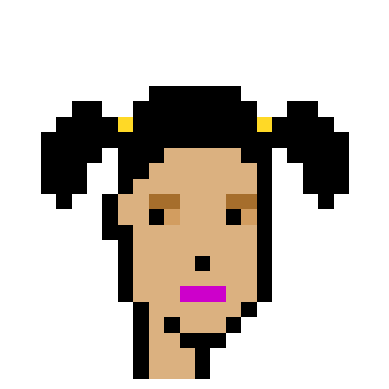

In [14]:
decoded = rand_punk()
print(decoded.shape)

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, straightHairDark, goldChain, nerdGlasses
Shape: torch.Size([4, 24, 24])


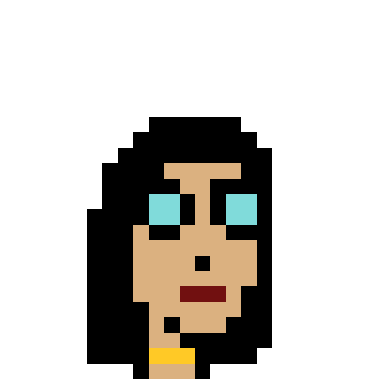

In [15]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: male, bigBeard, stringyHair
Shape: torch.Size([4, 24, 24])


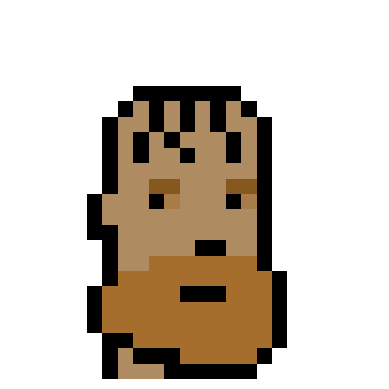

In [16]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, straightHair, mole, cigarette
Shape: torch.Size([4, 24, 24])


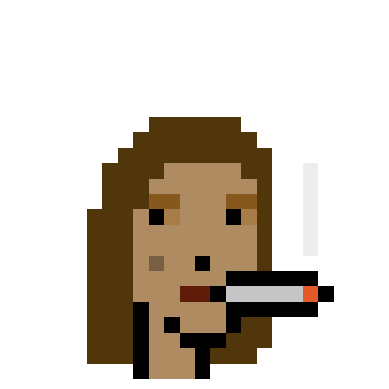

In [17]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


Features: female, mohawkDark, blackLipstick, earring
Shape: torch.Size([4, 24, 24])


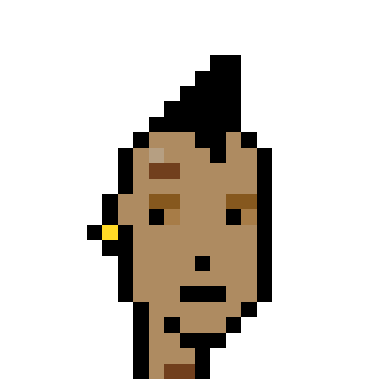

In [18]:
decoded = rand_punk()

plt.imshow(transforms.functional.to_pil_image(decoded))
plt.axis('off')
plt.show()


## Reconstruction

In [19]:
def reconstruct_punk(idx):
    punk = I.get_punk_tensor(idx)
    p = DS.rgba_to_one_hot(punk, dataset.mapper)
    p = p.unsqueeze(0)
    p = p.to(device)

    _, labels = dataset[idx]
    l = labels.unsqueeze(0)
    l = l.to(device)
    enabled_features = [k for k,v in zip(label_keys, labels) if v.item() == 1]

    model.eval()
    with torch.no_grad():
        reconstructed, mu, logvar = model.forward(p, l)

    recon_punk = reconstructed[0][:222, :, :].cpu()
    recon_punk = DS.one_hot_to_rgba(recon_punk, dataset.mapper)

    return punk, recon_punk, enabled_features


def draw_two(img1, img2):
    page_size = 2
    view_x, view_y = 4*page_size, 2*page_size
    fig = plt.figure(figsize=(view_x, view_y))
    fig.add_subplot(1, 2, 1)
    plt.imshow(transforms.functional.to_pil_image(img1))
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(transforms.functional.to_pil_image(img2))
    plt.axis('off')
    plt.show()


### 5 Reconstructions

Features: female, rosyCheeks, darkHair, cigarette


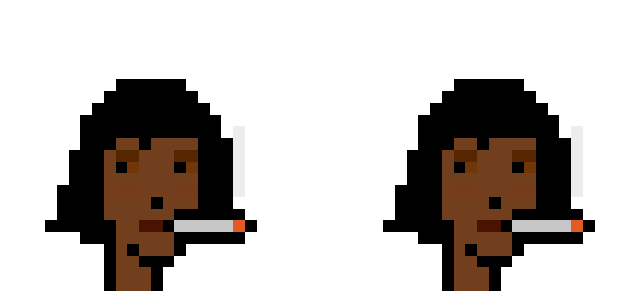

In [20]:
punk, recon_punk, features = reconstruct_punk(1000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: female, stringyHair, purpleLipstick, earring


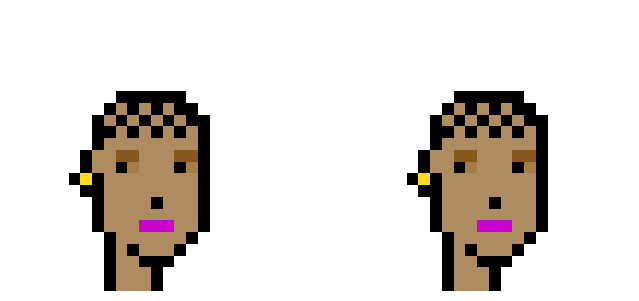

In [21]:
punk, recon_punk, features = reconstruct_punk(2001)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)


Features: female, wildWhiteHair, greenEyeShadow, hotLipstick


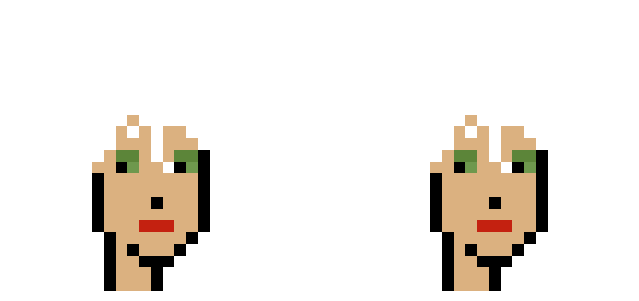

In [22]:
punk, recon_punk, features = reconstruct_punk(5000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, rosyCheeks, mustache, vr, cap, cigarette


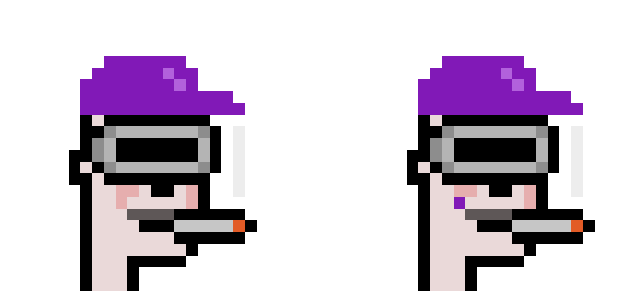

In [23]:
punk, recon_punk, features = reconstruct_punk(8000)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

Features: male, handlebars, bandana


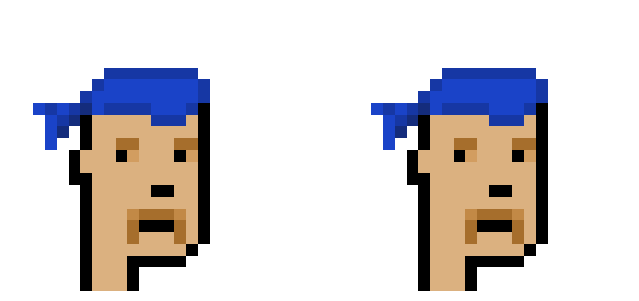

In [24]:
punk, recon_punk, features = reconstruct_punk(1337)

print(f"Features: {', '.join(features)}")
draw_two(punk, recon_punk)

## Losses

<function matplotlib.pyplot.show(close=None, block=None)>

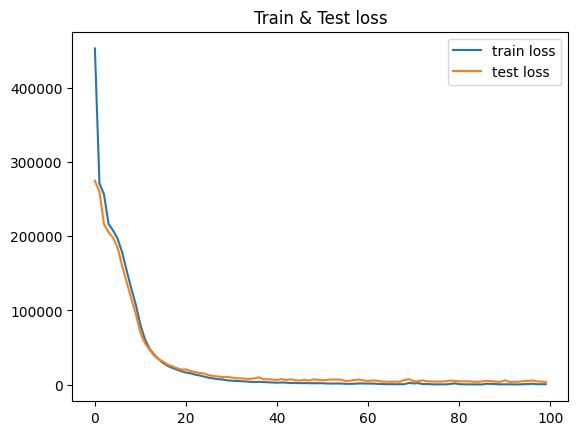

In [25]:
plt.title("Train & Test loss")
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show


In [26]:
train_losses


[452662.9915918661,
 270963.2442791445,
 256202.95919215426,
 216444.92256759753,
 207530.2558316711,
 196276.73854443704,
 177942.8904587766,
 152954.57197473405,
 129195.03338320035,
 107341.03520473183,
 80296.65528036347,
 60988.17629723515,
 48608.265320257095,
 40442.243271415115,
 34398.451899102394,
 29130.277759308512,
 25274.819100454344,
 22513.874323851673,
 20301.900345606162,
 18085.161875623337,
 16293.454359555075,
 15334.046265514184,
 13581.28570859652,
 12374.977932111591,
 10904.625709046708,
 9351.806666164533,
 8432.471729035073,
 7449.222678759419,
 7013.14026484929,
 5837.605791673593,
 5359.401850057832,
 4992.491526069371,
 4720.361607977685,
 4410.5029110739415,
 3886.6129019446407,
 3635.0794742665394,
 3789.4361831989695,
 3521.059992580549,
 3178.5932932102933,
 2954.9135328793354,
 2590.9812435934728,
 2968.851949488863,
 2691.066116982318,
 2120.587693992236,
 2373.626804000097,
 1985.0190412372563,
 2130.04888759099,
 1973.4673524680713,
 1946.530719351

In [27]:
test_losses


[274565.6923828125,
 259719.77856445312,
 216143.3243408203,
 205088.71728515625,
 197640.92578125,
 184636.54260253906,
 159490.21325683594,
 137449.11499023438,
 115709.59118652344,
 94836.8490600586,
 69563.99578857422,
 55921.02600097656,
 47125.12063598633,
 39251.31332397461,
 34420.16833496094,
 30982.737823486328,
 26911.011596679688,
 24843.802764892578,
 22089.49041748047,
 20418.769653320312,
 20520.81645965576,
 18370.768661499023,
 16943.51934814453,
 15712.145606994629,
 15046.260711669922,
 12801.904800415039,
 11771.541816711426,
 11045.050109863281,
 10389.722854614258,
 10393.947952270508,
 9615.070846557617,
 8586.751304626465,
 8508.26640701294,
 8039.341596603394,
 7807.2954959869385,
 8471.494291305542,
 9862.230693817139,
 7301.477319717407,
 7278.42523765564,
 6914.336235046387,
 6449.832180976868,
 7428.773725509644,
 6266.149059295654,
 7263.878799438477,
 6111.410852432251,
 5491.705003738403,
 6638.2053871154785,
 5442.097129821777,
 7055.374969482422,
 6616